# LSTM

Las redes neuronales LSTM están cambiando el aprendizaje profundo. Destacan en procesamiento de lenguaje, predicción temporal y reconocimiento de voz.

Las redes LSTM son un tipo especial de redes neuronales recurrentes. Procesan secuencias de datos y modelan el lenguaje. Capturan dependencias a largo plazo en los datos.

## Definición y findamentos

Una red LSTM tiene celdas de memoria que guardan información. Cada celda contiene tres puertas: entrada, olvido y salida. Estas puertas controlan el flujo de datos en la celda.

La red aprende qué información es importante. Decide qué datos conservar y cuáles descartar. Este proceso mejora su rendimiento en tareas complejas.

## Procesamiento del lenguaje natural

Las LSTM destacan en el procesamiento del lenguaje natural. Se usan para generar texto coherente y relevante. También son útiles en el modelado del lenguaje.

En el análisis de sentimientos, las LSTM examinan textos para detectar emociones. Esto es muy valioso para estudios de mercado y atención al cliente.

In [14]:
import pandas as pd
import numpy as np
import re
import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
# Cargar y limpiar datos
df = pd.read_csv('../data/train_preprocess_v1.csv')
df = df[['statement', 'party_affiliation', 'speaker', 'subject', 'label']].dropna()

Tokenizer es una utilidad de Keras que convierte texto en secuencias numéricas.

- num_words=10000: solo mantendrá las 10.000 palabras más frecuentes.

- oov_token="OOV": las palabras que no estén en el vocabulario serán reemplazadas por el token especial OOV ("Out Of Vocabulary").

Creamos el vocabulario a partir de la columna statement del dataframe y asignamos un índice único a cada palabra según su frecuencia.

'seqs' convierte cada frase en una lista de enteros: cada palabra se reemplaza por su índice en el vocabulario.

'max_len' se utiliza para rellenar o recortar todas las secuencias para que tengan longitud fija de 100 tokens (para poder entrenar una red neuronal que espera entradas de tamaño fijo).

Después creamos tres codificadores (LabelEnccoder) para convertir texto categórico en números. Y juntamos los 3 vectores categóricos en una única matrix de forma (n_samples, 3)

In [34]:
# Texto
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['statement'])
seqs = tokenizer.texts_to_sequences(df['statement'])
max_len = 100
X_text = pad_sequences(seqs, maxlen=max_len)

# Categóricos
le_party = LabelEncoder()
le_speaker = LabelEncoder()
le_subject = LabelEncoder()

X_party = le_party.fit_transform(df['party_affiliation'].fillna("Unknown"))
X_speaker = le_speaker.fit_transform(df['speaker'].fillna("Unknown"))
X_subject = le_subject.fit_transform(df['subject'].fillna("Unknown"))

# Juntar los categóricos en una matriz
X_cat = np.stack([X_party, X_speaker, X_subject], axis=1)

In [35]:
# Codificar etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

Dividimos el dataset en 80% entrenamiento y 20% test.

Datos clave:
- stratify=y: asegura que la proporción de clases (falsas/verdaderas) se mantenga igual en los conjuntos de entrenamiento y test.

- random_state=42: fija una semilla para que la partición sea reproducible.

In [36]:
# División en train/test
from sklearn.model_selection import train_test_split

X_text_train, X_text_test, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    X_text, X_cat, y, test_size=0.2, stratify=y, random_state=42
)

## Definición del modelo LSTM

A continuación se define un modelo multientrada en Keras que combina texto (con LSTM) y variables categóricas.

En este modelo la capa de embedding convierte índices de palabras en vectores densos de tamaño 128 y se utiliza una LSTM que extrae representaciones de contexto del texto con 64 unidades ocultas.

Se define también la entrada con 3 características categóricas ya codificadas y la capa densa para procesar estas variables.

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate

# Input 1: texto
text_input = Input(shape=(max_len,), name="text_input")
x = Embedding(input_dim=10000, output_dim=128)(text_input)
x = LSTM(64)(x)

# Input 2: categóricos
meta_input = Input(shape=(3,), name="meta_input")
y = Dense(32, activation='relu')(meta_input)


Posteriormente juntamos la representación del texto con la de los metadatos, regularizamos la red para evitar overfitting, definimos la capa oculta intermedia y la capa de salida binaria y compilamos el modelo

In [38]:
# Fusionar y seguir
combined = Concatenate()([x, y])
z = Dropout(0.5)(combined)
z = Dense(32, activation='relu')(z)
output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[text_input, meta_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 100, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │     49,408 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │        128 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 96)        │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 96)        │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      3,104 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         33 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,332,673 (5.08 MB)

 Trainable params: 1,332,673 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo

Con 'EarlyStopping'

- compute_class_weight calcula pesos para que las clases minoritarias tengan más importancia.

- Esto es útil si, por ejemplo, hay muchas más afirmaciones verdaderas que falsas (o viceversa).

- Se convierte a dict porque Keras espera un diccionario como {0: peso0, 1: peso1}.

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

history = model.fit(
    {"text_input": X_text_train, "meta_input": X_cat_train},
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)


Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5337 - loss: 6.2777 - val_accuracy: 0.6215 - val_loss: 1.5328
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6241 - loss: 2.4629 - val_accuracy: 0.5168 - val_loss: 1.9617
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7124 - loss: 1.3443 - val_accuracy: 0.5182 - val_loss: 2.0002


## Evaluación del modelo

Aplicamos un umbral de 0.5 para convertir las probabilidades en etiquetas: >= 0.5 → 1 (Fake), < 0.5 → 0 (Real).

In [44]:
y_pred = model.predict({"text_input": X_text_test, "meta_input": X_cat_test})
y_pred_label = (y_pred > 0.5).astype(int).flatten()

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_label, digits=4))

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

           0     0.4620    0.3661    0.4085       631
           1     0.6899    0.7679    0.7268      1159

    accuracy                         0.6263      1790
   macro avg     0.5760    0.5670    0.5677      1790
weighted avg     0.6096    0.6263    0.6146      1790



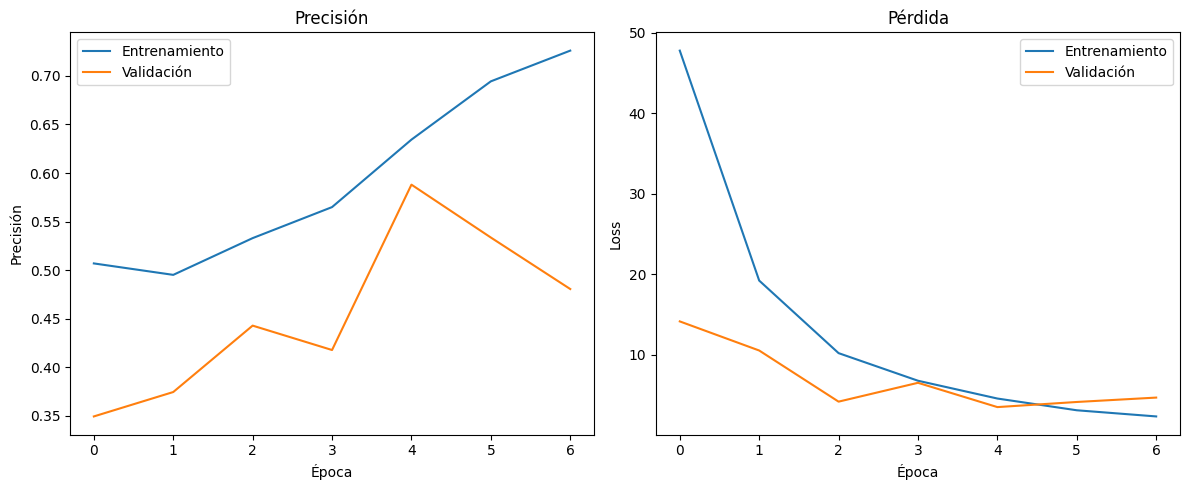

In [32]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Entrenamiento")
plt.plot(history.history['val_accuracy'], label="Validación")
plt.title("Precisión")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Entrenamiento")
plt.plot(history.history['val_loss'], label="Validación")
plt.title("Pérdida")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## Generación de archivo de predicciones

In [33]:
# 1. Carga tu archivo de test sin etiquetas
test_df = pd.read_csv("../data/test_preprocess_v1.csv")

# 2. Preprocesa el texto igual que en entrenamiento
test_seqs = tokenizer.texts_to_sequences(test_df['statement'])
X_text_test = pad_sequences(test_seqs, maxlen=max_len)

# 3. Preprocesa las columnas categóricas con los label encoders entrenados
# Aquí asegúrate que test_df tiene esas columnas, si no, adapta según tu dataset

X_party_test = le_party.transform(test_df['party_affiliation'].fillna("Unknown"))
# Asegurarse de que 'Unknown' fue parte del entrenamiento
if "Unknown" not in le_speaker.classes_:
    le_speaker.classes_ = np.append(le_speaker.classes_, "Unknown")

# Reemplazar valores no vistos por 'Unknown'
test_df['speaker'] = test_df['speaker'].apply(
    lambda x: x if x in le_speaker.classes_ else "Unknown"
)
X_speaker_test = le_speaker.transform(test_df['speaker'].fillna("Unknown"))
# Asegurarse de que 'Unknown' fue parte del entrenamiento
if "Unknown" not in le_subject.classes_:
    le_subject.classes_ = np.append(le_subject.classes_, "Unknown")

# Reemplazar valores no vistos por 'Unknown'
test_df['subject'] = test_df['subject'].apply(
    lambda x: x if x in le_subject.classes_ else "Unknown"
)
X_subject_test = le_subject.transform(test_df['subject'].fillna("Unknown"))

X_cat_test = np.stack([X_party_test, X_speaker_test, X_subject_test], axis=1)

# 4. Realiza las predicciones
y_pred_prob = model.predict({"text_input": X_text_test, "meta_input": X_cat_test})

# 5. Convierte probabilidades a etiquetas binarias
y_pred_labels = (y_pred_prob > 0.5).astype(int).flatten()

# 6. Guarda el resultado en CSV con el formato esperado
submission_df = pd.DataFrame({
    "id": test_df["id"],   # Ajusta si tu test tiene columna 'id'
    "label": y_pred_labels
})

submission_df.to_csv("submission_lstm_metadatos.csv", index=False)
print("Archivo de predicción generado: submission_lstm_metadatos.csv")

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Archivo de predicción generado: submission_lstm_metadatos.csv
